# Week 13: Unsupervised Learning (Hierarchical clustering and DBSCAN)

```
- Machine Learning, Innopolis University (Fall semester 2022)
- Professor: Adil Khan
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
In this lab, you will practice Clustering techniques

Lab Plan
1. Hierarchical clustering
2. DBSCAN
```

<hr>


![](https://miro.medium.com/max/1400/1*Ewg7z7YxEXbjECkHPdtrvA.png)

## 1. Hierarchical Clustering

We will compare between different types of linkage algorithm in different datasets.

#### Differences between Hierarchical clustering and KMeans:
1. Each run of KMeans on the same data is different, but in HC will be the same.
2. For hyper-spherical clusters shape, k-means works better.
3. Time complexity is proportional to the square of #points in HC while K-Means is linearly proportional.

---

## Data generation

In [1]:
import time
import warnings
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import cluster
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropic distributed data
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

## Trying different types of linkage algorithms in Agglomerative Hierarchical Clustering


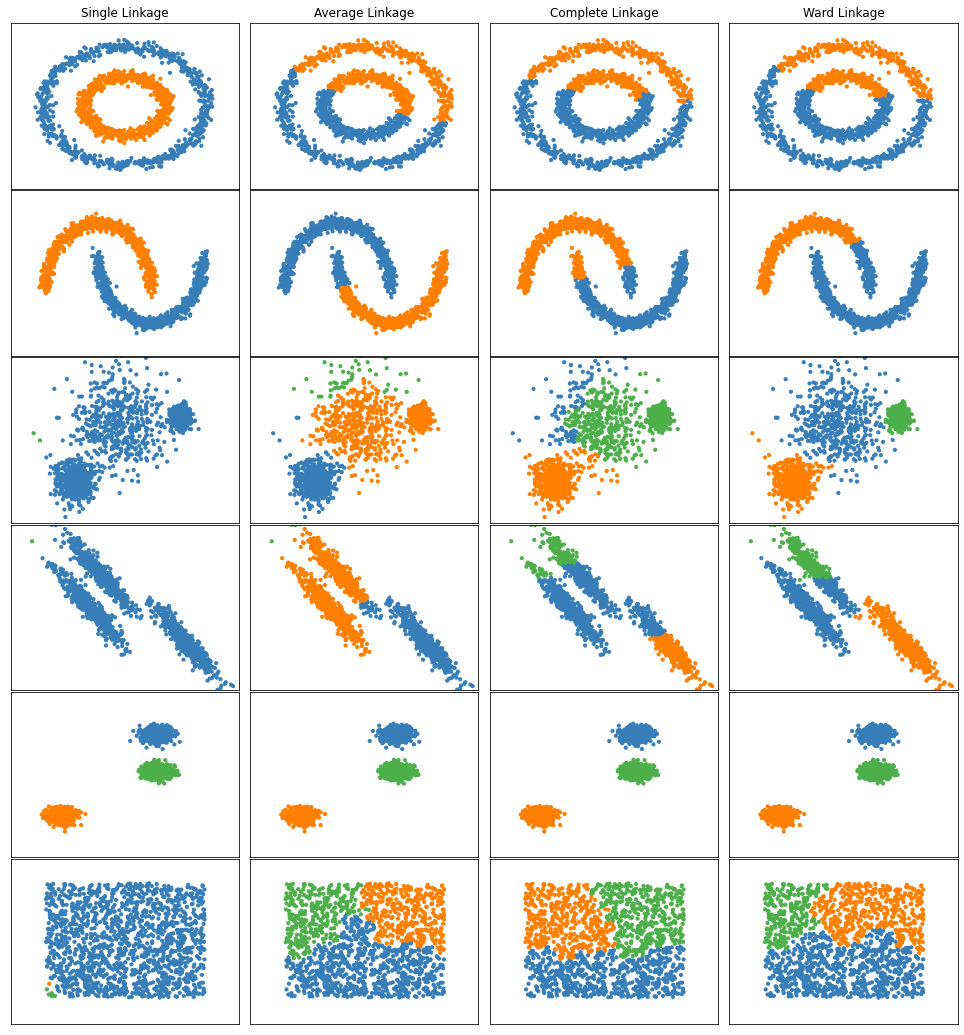

In [2]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {}),
    (aniso, {}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset
    X = StandardScaler().fit_transform(X)

    # Create cluster objects
    ward = AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())

        plot_num += 1

plt.show()

## 4. DBSCAN

What's the pros and cons of DBSCAN?

<span style="color:blue">
Pros:

1. Discovers arbitrary shapes clusters
2. Robust towards outliers/noise

Cons:
1. Not efficient at clustering data with varying densities and sizes.
2. Sensitive to clustering params: minPoints & EPS
3. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.

In [4]:
from sklearn.neighbors import kneighbors_graph

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'n_neighbors': 10,
                'n_clusters': 3
                }

datasets = [
    (noisy_circles, {'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Create cluster objects
    ms = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (
        ('KMeans', ms),
        ('DBSCAN', dbscan)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right'
                )
        plot_num += 1

plt.subplots_adjust(right=0.3)
plt.show()

NameError: name 'plt' is not defined

## Self Practice task

Using [UNSW-NB15 Dataset](https://www.dropbox.com/s/nsvgwps3abdoxnq/clustering_data.zip?dl=1):

1. Preprocess the dataset
2. Reduce dimension using PCA
3. Remove outliers
4. Cluster the data using Agglomerative Clustering, DBSCAN and Kmeans. Find the optimal number of clusters for each method
5. Visualize the data clusters (use PCA with 2 components)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchmetrics import F1Score, Accuracy
import time
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
data_train = pd.read_csv('data/trainset.csv')
data_test = pd.read_csv('data/testset.csv')

In [3]:
data_train.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,1,0,0,0,1,1,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,1,2,0,0,0,1,6,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,2,1,1,3,0,0,0,2,6,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,2,1,1,3,1,1,0,2,1,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,2,1,40,0,0,0,2,39,0


In [4]:
object_columns = list(data_train.columns[data_train.dtypes == object])
data_to_encode = data_train[object_columns].copy()

In [5]:
data_train.mask(abs(data_train[data_train.columns[data_train.dtypes != object]].apply(zscore)) > 3, inplace=True)
data_train[object_columns] = data_to_encode
data_train.dropna(inplace=True)

In [6]:
# encoding
from sklearn.preprocessing import LabelEncoder
labele = LabelEncoder()
data_train[object_columns[0]] = labele.fit_transform(data_train[object_columns[0]])
data_train[object_columns[1]] = labele.fit_transform(data_train[object_columns[1]])
data_train[object_columns[2]] = labele.fit_transform(data_train[object_columns[2]])

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_train = StandardScaler().fit_transform(data_train)
pca = PCA(n_components=2)
data_train = pca.fit_transform(data_train)

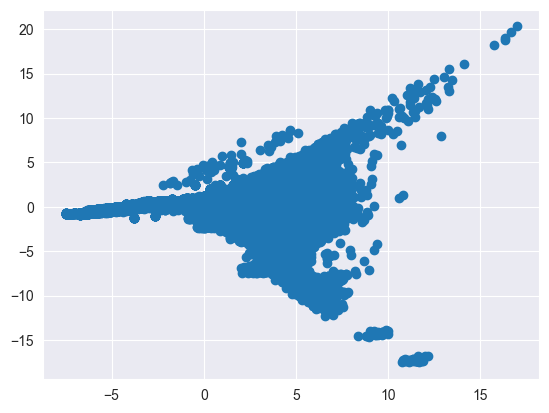

In [8]:
plt.scatter(data_train[:,0],data_train[:,1])
plt.show()

### K-means

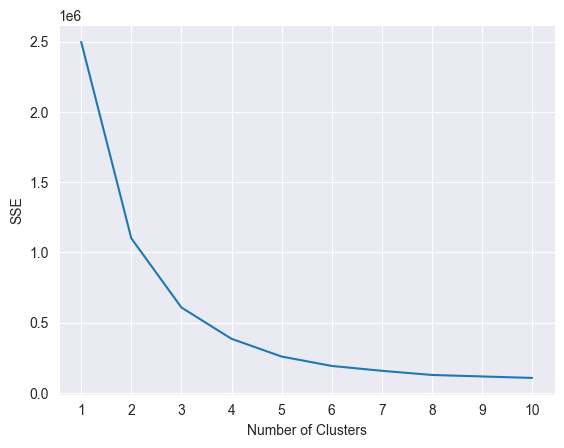

In [9]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_train)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

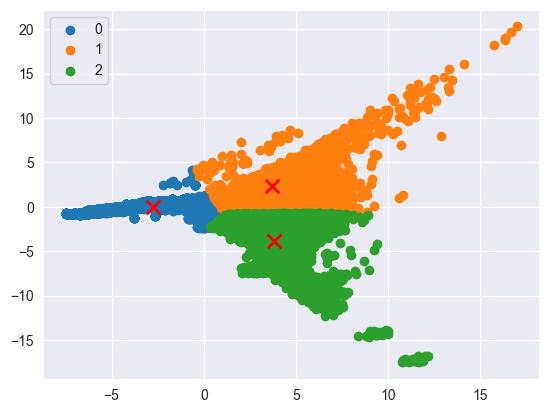

In [10]:
kmeans = KMeans(init="random", n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(data_train)
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(data_train[label == i , 0] , data_train[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x', s=100, color='r', linewidths=2)
plt.legend()
plt.show()

### DBSCAN

Text(0, 0.5, 'Distance')

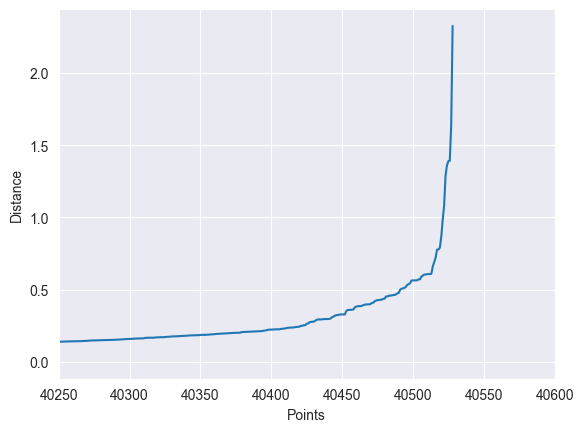

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

data = data_train[:int(data_train.shape[0]*0.3), :]

nearest_neighbors = NearestNeighbors(n_neighbors=10)
neighbors = nearest_neighbors.fit(data)

distances, indices = neighbors.kneighbors(data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]


plt.plot(distances)
# plt.xlim(40250)
plt.xlim(40250, 40600)
plt.xlabel("Points")
plt.ylabel("Distance") # 0.5 eps seems ok

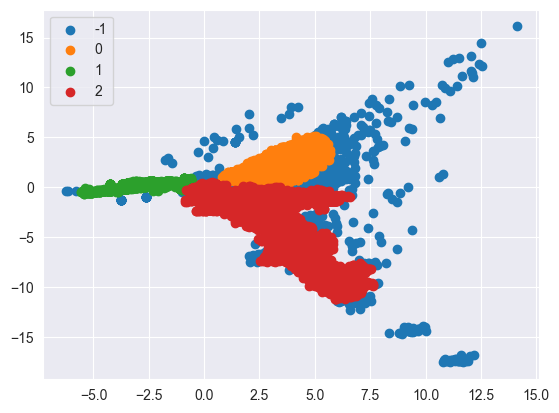

In [12]:
dbscan = DBSCAN(eps=0.5, min_samples=90)
label = dbscan.fit_predict(data)
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
# plt.scatter(dbscan.cluster_centers_[:,0], dbscan.cluster_centers_[:,1], marker='x', s=100, color='r', linewidths=2)
plt.legend()
plt.show()

### Agglomerative Clustering

In [33]:
data = data_train[:int(data_train.shape[0]*0.1), :]

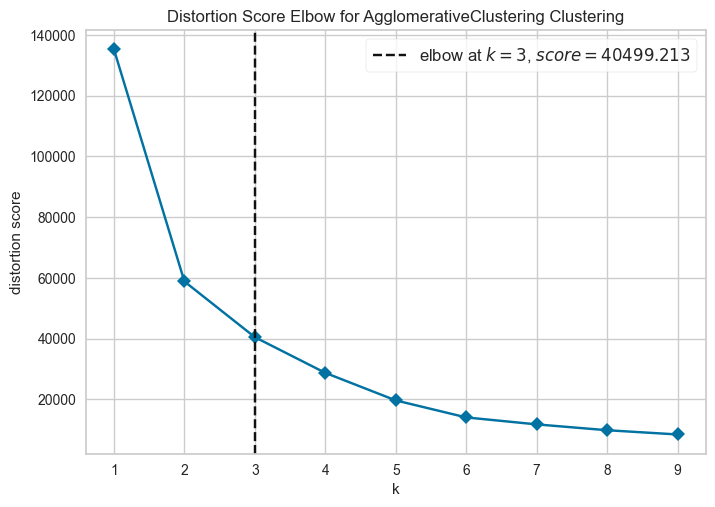

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering()

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)
# Fit data to visualizer
visualizer.fit(data)
# Finalize and render figure
visualizer.show()

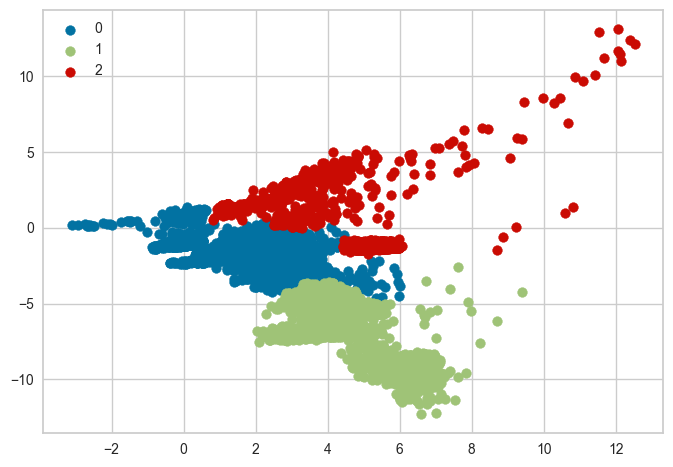

In [56]:
agg = AgglomerativeClustering(n_clusters=3)
label = agg.fit_predict(data)
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
# plt.scatter(agg.cluster_centers_[:,0],agg.cluster_centers_[:,1], marker='x', s=100, color='r', linewidths=2)
plt.legend()
plt.show()